In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json


In [13]:
# Met à jour ce chemin avec le tien
DATASET_PATH = "D:/intro-deep-machi/images"
JSON_PATH = "D:/intro-deep-machi/imagenet_class_index.json"

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
SEED = 42


In [14]:
def data_counter(file_path):
    image_counter = 0
    folder_set = set()
    for dirname, _, filenames in os.walk(file_path):
        for filename in filenames:
            if filename.endswith('.JPEG') or filename.endswith('.jpg'):
                image_counter += 1
            folder_set.add(dirname)
    folder_counter = len(folder_set) - 1  # Remove root
    return folder_counter, image_counter

class_num, image_num = data_counter(DATASET_PATH)
print("--- ImageNet Mini Dataset ---")
print("Total Class:", class_num)
print("Total Images:", image_num)


--- ImageNet Mini Dataset ---
Total Class: 999
Total Images: 3923


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3706 images belonging to 1000 classes.
Found 217 images belonging to 1000 classes.


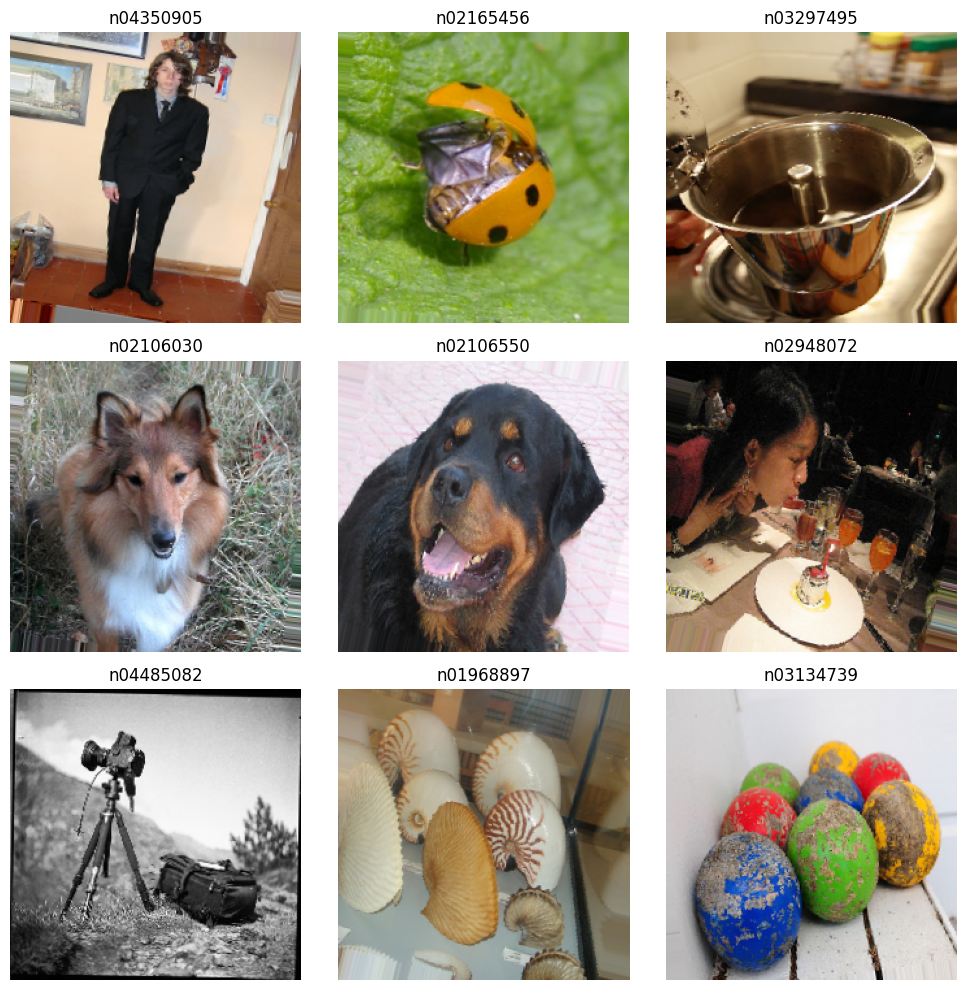

In [16]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    class_name = list(train_generator.class_indices.keys())[label_idx]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # On "gèle" la base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('resnet50_best_model.keras', save_best_only=True)
]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
 26/116 ━━━━━━━━━━━━━━━━━━━━ 8:27 6s/step - accuracy: 0.0019 - loss: 7.0773

In [10]:
print(train_generator.class_indices)
print(train_generator.num_classes)


{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9, 'n01530575': 10, 'n01531178': 11, 'n01532829': 12, 'n01534433': 13, 'n01537544': 14, 'n01558993': 15, 'n01560419': 16, 'n01580077': 17, 'n01582220': 18, 'n01592084': 19, 'n01601694': 20, 'n01608432': 21, 'n01614925': 22, 'n01616318': 23, 'n01622779': 24, 'n01629819': 25, 'n01630670': 26, 'n01631663': 27, 'n01632458': 28, 'n01632777': 29, 'n01641577': 30, 'n01644373': 31, 'n01644900': 32, 'n01664065': 33, 'n01665541': 34, 'n01667114': 35, 'n01667778': 36, 'n01669191': 37, 'n01675722': 38, 'n01677366': 39, 'n01682714': 40, 'n01685808': 41, 'n01687978': 42, 'n01688243': 43, 'n01689811': 44, 'n01692333': 45, 'n01693334': 46, 'n01694178': 47, 'n01695060': 48, 'n01697457': 49, 'n01698640': 50, 'n01704323': 51, 'n01728572': 52, 'n01728920': 53, 'n01729322': 54, 'n01729977': 55, 'n01734418': 56, 'n01735189': 57, 'n01737021': 58, 'n0173

In [11]:
loss, acc = model.evaluate(val_generator)
print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.0012 - loss: 7.8857    
Loss: 7.8127, Accuracy: 0.0046
